# Step 1: Preprocessing with Feature Mapping (using ResNet18)


In [1]:
import os
import pennylane as qml
from pennylane import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torchvision.transforms as transforms
from torchvision import models

# Constants
SOI_PATH = '/home/HardDisk/yared/spectrogram-dataset/soi'
CWI_PATH = '/home/HardDisk/yared/spectrogram-dataset/cwi'
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32

# Preprocessing and ResNet feature extractor
device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnet = models.resnet18(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # Remove last layer
resnet = resnet.to(device)

# Updated transformation pipeline
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels (RGB)
    transforms.ToTensor()
])

def load_images(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)
            img_tensor = transform(img).unsqueeze(0).to(device)
            features = resnet(img_tensor).cpu().detach().numpy().flatten()
            images.append(features)
            labels.append(label)
    return images, labels

# Load images and labels
soi_images, soi_labels = load_images(SOI_PATH, 0)
cwi_images, cwi_labels = load_images(CWI_PATH, 1)

# Combine and normalize features
X = np.array(soi_images + cwi_images)
X = (X - X.min()) / (X.max() - X.min())  # Normalize to [0, 1]

# Apply PCA for dimensionality reduction
pca = PCA(n_components=10)  # I can further adjust the number of components; maybe later
X_reduced = pca.fit_transform(X)

# Combine labels
y = np.array(soi_labels + cwi_labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42, stratify=y)

# Example output shapes
print(f'Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}')
print(f'Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}')


/home/ea301b/anaconda3/envs/Pennylane/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ea301b/anaconda3/envs/Pennylane/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ea301b/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 102MB/s] 


Training data shape: (6532, 10), Training labels shape: (6532,)
Testing data shape: (1634, 10), Testing labels shape: (1634,)


In [2]:
# Check the number of samples in each label for training and testing sets
train_labels, train_counts = np.unique(y_train, return_counts=True)
test_labels, test_counts = np.unique(y_test, return_counts=True)

# Print the number of samples for each label in the training set
print("Training set label distribution:")
for label, count in zip(train_labels, train_counts):
    print(f'Label {label}: {count} samples')

# Print the number of samples for each label in the testing set
print("Testing set label distribution:")
for label, count in zip(test_labels, test_counts):
    print(f'Label {label}: {count} samples')

Training set label distribution:
Label 0: 4767 samples
Label 1: 1765 samples
Testing set label distribution:
Label 0: 1193 samples
Label 1: 441 samples


# Step 2: Define the Quantum Circuit and QNN

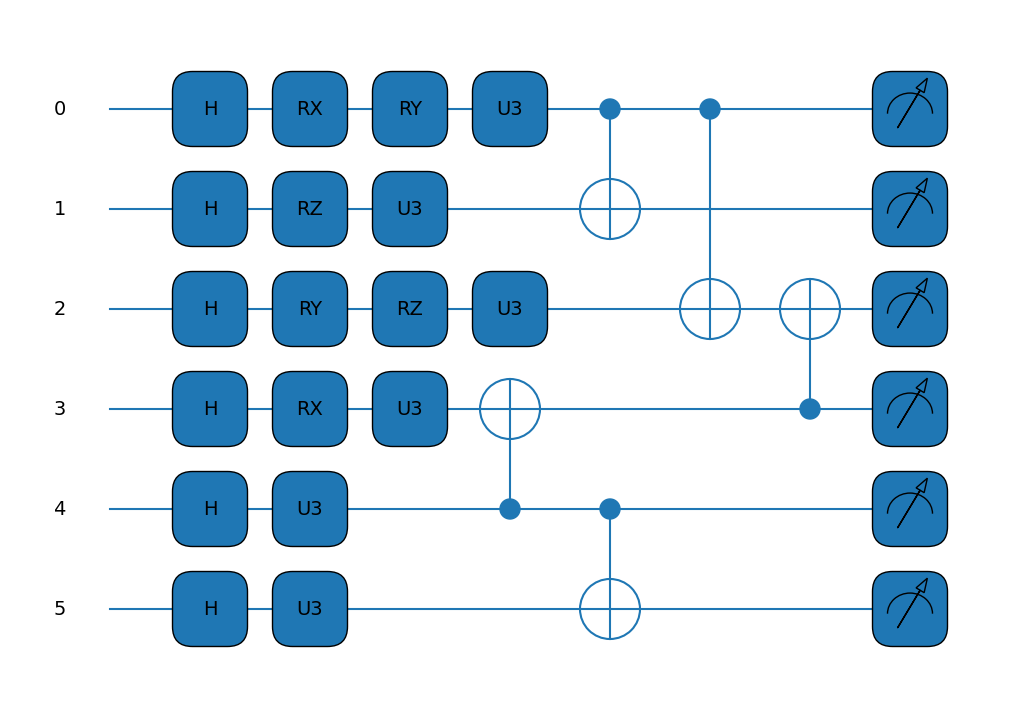

In [3]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import torch

# Quantum device setup
n_qubits = 6  # Adjust based on the number of qubits needed
dev = qml.device("default.qubit", wires=n_qubits)

# Define the quantum circuit
@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs, weights):
    """Define a variational quantum circuit that matches the specified LaTeX structure."""

    # Step 1: Apply Hadamard gates to each qubit as per the initial superposition setup
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Step 2: Apply specific rotation gates on specified qubits
    qml.RX(inputs[0], wires=0)  # Rx on qubit 1
    qml.RY(inputs[1], wires=0)  # Ry on qubit 1
    qml.RZ(inputs[2], wires=1)  # Rz on qubit 2
    qml.RY(inputs[3], wires=2)  # Ry on qubit 3
    qml.RZ(inputs[4], wires=2)  # Rz on qubit 3
    qml.RX(inputs[5], wires=3)  # Rx on qubit 4

    # Step 3: Apply unitary gates (U(alpha), U(beta), ...) as U3 gates
    qml.U3(weights[0, 0, 0], weights[0, 0, 1], weights[0, 0, 2], wires=0)  # U(alpha) on qubit 1
    qml.U3(weights[0, 1, 0], weights[0, 1, 1], weights[0, 1, 2], wires=1)  # U(beta) on qubit 2
    qml.U3(weights[0, 2, 0], weights[0, 2, 1], weights[0, 2, 2], wires=2)  # U(delta) on qubit 3
    qml.U3(weights[0, 3, 0], weights[0, 3, 1], weights[0, 3, 2], wires=3)  # U(epsilon) on qubit 4
    qml.U3(weights[0, 4, 0], weights[0, 4, 1], weights[0, 4, 2], wires=4)  # U(zeta) on qubit 5
    qml.U3(weights[0, 5, 0], weights[0, 5, 1], weights[0, 5, 2], wires=5)  # U(eta) on qubit 6

    # Step 4: Apply entangling CNOT gates to match specified connections
    qml.CNOT(wires=[0, 1])  # Control qubit 1 to target qubit 2
    qml.CNOT(wires=[0, 2])  # Control qubit 1 to target qubit 3
    qml.CNOT(wires=[4, 3])  # Control qubit 4 to target qubit 5
    qml.CNOT(wires=[3, 2])  # Control qubit 4 to target qubit 3
    qml.CNOT(wires=[4, 5])  # Control qubit 4 to target qubit 3

    # Step 5: Measurements on all qubits
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define the weight shape dictionary for TorchLayer
weights_shape = {"weights": (1, n_qubits, 3)}

# QNN model that uses the defined quantum circuit
qnn = qml.qnn.TorchLayer(quantum_circuit, weights_shape)

# Visualize the circuit
inputs = np.random.rand(n_qubits)  # Random input values for the gates
weights = np.random.rand(1, n_qubits, 3)  # Random weights for the U3 unitaries
fig, ax = qml.draw_mpl(quantum_circuit)(inputs, weights)
plt.show()


# Step 3: Combine ResNet-18 and QNN for Classification

In [4]:
import torch.nn as nn

class HybridModel(nn.Module):
    def __init__(self, input_size):
        super(HybridModel, self).__init__()
        self.fc = nn.Linear(input_size, n_qubits)  # ResNet18 output to qubit input size
        self.qnn = qnn
        self.output = nn.Linear(n_qubits, 1)  # Binary classification
    
    def forward(self, x):
        x = self.fc(x)
        x = self.qnn(x)
        x = torch.sigmoid(self.output(x))
        return x

# Step 4: Train and Evaluate the Model

# The mighty FGSM Attack

In [5]:
import torch.nn.functional as F

def fgsm_attack(model, X, y, epsilon):
    X_adv = X.clone().detach().requires_grad_(True)
    output = model(X_adv).squeeze(1)
    loss = F.binary_cross_entropy(output, y)
    model.zero_grad()
    loss.backward()
    grad_sign = X_adv.grad.data.sign()
    X_adv = X_adv + epsilon * grad_sign
    X_adv = torch.clamp(X_adv, 0, 1)
    return X_adv

In [6]:
def test_model(model, test_loader, epsilon):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    test_correct = 0
    y_pred = []
    y_true = []
    
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
        
        # Generate adversarial examples using FGSM
        X_batch_adv = fgsm_attack(model, X_batch, y_batch, epsilon)
        
        with torch.no_grad():
            output = model(X_batch_adv).squeeze(1)
            loss = F.binary_cross_entropy(output, y_batch)
            test_loss += loss.item() * X_batch.size(0)
            predictions = (output > 0.5).float()
            test_correct += (predictions == y_batch).float().sum().item()
            y_pred.extend(predictions.cpu().numpy())
            y_true.extend(y_batch.cpu().numpy())
    
    # Calculate metrics
    avg_test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = test_correct / len(test_loader.dataset)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    return avg_test_loss, test_accuracy, precision, recall, f1


In [ ]:
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Assuming 'X_train', 'y_train', 'X_test', 'y_test', 'BATCH_SIZE', and 'HybridModel' are defined

X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train  # Ensures the class distribution is balanced
)

train_data = TensorDataset(
    torch.tensor(X_train_split, dtype=torch.float32),
    torch.tensor(y_train_split, dtype=torch.float32)
)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

val_data = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32)
)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

test_data = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32)
)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

input_size = X_train_split.shape[1]  # Number of features after PCA
model = HybridModel(input_size=input_size).cuda()

class_labels, class_counts = np.unique(y_train_split, return_counts=True)
total_samples = len(y_train_split)

class_weights = [total_samples / (2 * count) if count > 0 else 0.0 for count in class_counts]

weights_tensor = torch.tensor(class_weights, dtype=torch.float32).cuda()

optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

epochs = 25
loss_values = []
accuracy_values = []
val_losses = []
val_accuracy_values = []
test_losses = []
test_accuracy_values = []

def train_model(epochs):
    for epoch in range(epochs):
        # Training Phase
        model.train()
        total_loss = 0.0
        correct = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            optimizer.zero_grad()
            
            output = model(X_batch).squeeze(1)
            weights = weights_tensor[y_batch.long()]
            loss = F.binary_cross_entropy(output, y_batch, weight=weights)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * X_batch.size(0)
            correct += ((output > 0.5) == y_batch).float().sum().item()
        
        avg_loss = total_loss / len(train_loader.dataset)
        accuracy = correct / len(train_loader.dataset)
        loss_values.append(avg_loss)
        accuracy_values.append(accuracy)
        
        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        y_pred = []
        y_true = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
                output = model(X_batch).squeeze(1)
                loss = F.binary_cross_entropy(output, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                predictions = (output > 0.5).float()
                val_correct += (predictions == y_batch).float().sum().item()
                y_pred.extend(predictions.cpu().numpy())
                y_true.extend(y_batch.cpu().numpy())
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = val_correct / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        val_accuracy_values.append(val_accuracy)
        
        # Testing Phase with FGSM after each epoch
        epsilon = 0.10  # Because the model has shown serious accuracy drop here
        avg_test_loss, test_accuracy, precision, recall, f1 = test_model(model, test_loader, epsilon)
        test_losses.append(avg_test_loss)
        test_accuracy_values.append(test_accuracy)
        
        # Print the result for the current epoch
        print(f"\nEpoch {epoch + 1}/{epochs}, "
              f"Train Loss: {avg_loss:.4f}, Train Acc: {accuracy:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}, "
              f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.4f}, "
              f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Call the train_model function to start training
train_model(epochs)


Epoch 1/25, Train Loss: 0.6941, Train Acc: 0.2702, Val Loss: 0.6981, Val Acc: 0.2701, Test Loss: 0.7027, Test Acc: 0.2699, Precision: 0.2699, Recall: 1.0000, F1 Score: 0.4251

Epoch 2/25, Train Loss: 0.6890, Train Acc: 0.6341, Val Loss: 0.6869, Val Acc: 0.6963, Test Loss: 0.6964, Test Acc: 0.4461, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000

Epoch 3/25, Train Loss: 0.6819, Train Acc: 0.6932, Val Loss: 0.6733, Val Acc: 0.7406, Test Loss: 0.6972, Test Acc: 0.6181, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000

Epoch 4/25, Train Loss: 0.6652, Train Acc: 0.7246, Val Loss: 0.6387, Val Acc: 0.7582, Test Loss: 0.6990, Test Acc: 0.6897, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000

Epoch 5/25, Train Loss: 0.6315, Train Acc: 0.7353, Val Loss: 0.6023, Val Acc: 0.7475, Test Loss: 0.7318, Test Acc: 0.5520, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000

Epoch 6/25, Train Loss: 0.5851, Train Acc: 0.7257, Val Loss: 0.5608, Val Acc: 0.7414, Test Loss: 0.7845, Test Acc: 0.50

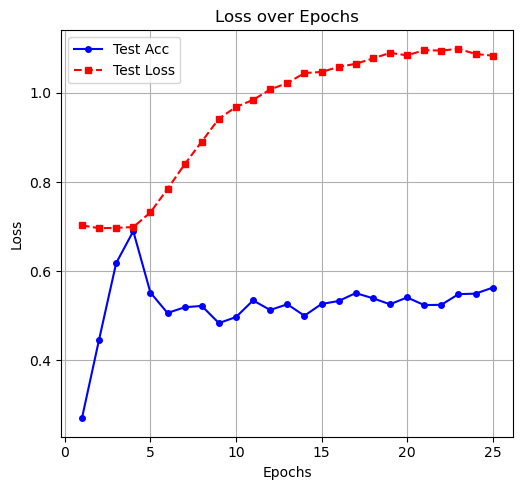

In [8]:
import matplotlib.pyplot as plt

# Function to plot loss and accuracy
def plot_loss_accuracy(loss_values, val_losses):
    epochs = range(1, len(loss_values) + 1)

    plt.figure(figsize=(10, 5))

    # Plot Loss (Training and Validation)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_values, label='Test Acc', color='blue', marker='o', markersize=4, linestyle='-')
    plt.plot(epochs, val_losses, label='Test Loss', color='red', marker='s', markersize=4, linestyle='--')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plotting function after training
plot_loss_accuracy(test_accuracy_values, test_losses)

In [9]:
test_accuracy_values

[0.26988984088127294,
 0.44614443084455324,
 0.6181150550795593,
 0.6897184822521419,
 0.5520195838433293,
 0.5061199510403916,
 0.5189718482252142,
 0.52203182374541,
 0.4834761321909425,
 0.4969400244798042,
 0.5342717258261934,
 0.5128518971848225,
 0.5257037943696451,
 0.5,
 0.5263157894736842,
 0.533047735618115,
 0.5507955936352509,
 0.5391676866585068,
 0.5257037943696451,
 0.5410036719706243,
 0.5238678090575275,
 0.5244798041615667,
 0.5483476132190942,
 0.5495716034271726,
 0.5630354957160343]

In [10]:
test_losses

[0.7026763397156098,
 0.6964363678286679,
 0.6971639137227211,
 0.6990141530077781,
 0.731769855705294,
 0.7844755742949693,
 0.8397784434450446,
 0.8907335799647953,
 0.9419980047674191,
 0.9684817007443021,
 0.9843558081068928,
 1.0077462958005534,
 1.022175243318154,
 1.04455853901995,
 1.047073503238043,
 1.05835629166121,
 1.0653492912668348,
 1.077345359646413,
 1.0898234272966187,
 1.084352435140598,
 1.0959321407822384,
 1.09504999094523,
 1.0990223614647163,
 1.087395872378145,
 1.0836941148251331]

# Marching the FGSM function. "Job-Make it stealth and remain unnoticed"

In [11]:
def test_model(model, test_loader, epsilon):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    test_correct = 0
    y_pred = []
    y_true = []
    
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
        X_batch_adv = fgsm_attack(model, X_batch, y_batch, epsilon)
        with torch.no_grad():
            output = model(X_batch_adv).squeeze(1)
            loss = F.binary_cross_entropy(output, y_batch)
            test_loss += loss.item() * X_batch.size(0)
            predictions = (output > 0.5).float()
            test_correct += (predictions == y_batch).float().sum().item()
            y_pred.extend(predictions.cpu().numpy())
            y_true.extend(y_batch.cpu().numpy())
    
    # Calculate metrics
    avg_test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = test_correct / len(test_loader.dataset)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    return avg_test_loss, test_accuracy, precision, recall, f1


# Very small perturbation compared to previous works

In [12]:
# List of epsilon values to test
epsilons = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1]

results = {}
for epsilon in epsilons:
    print(f"\nTesting with epsilon = {epsilon}")
    avg_test_loss, test_accuracy, precision, recall, f1 = test_model(model, test_loader, epsilon)
    
    # Store results
    results[epsilon] = {
        'Test Loss': avg_test_loss,
        'Test Accuracy': test_accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }
    
    # Print results for this epsilon
    print(f"Epsilon: {epsilon:.2f}, "
          f"Test Loss: {avg_test_loss:.4f}, "
          f"Test Accuracy: {test_accuracy:.4f}, "
          f"Precision: {precision:.4f}, "
          f"Recall: {recall:.4f}, "
          f"F1 Score: {f1:.4f}")



Testing with epsilon = 0.01
Epsilon: 0.01, Test Loss: 0.4862, Test Accuracy: 0.7613, Precision: 0.8493, Recall: 0.1406, F1 Score: 0.2412

Testing with epsilon = 0.02
Epsilon: 0.02, Test Loss: 0.5328, Test Accuracy: 0.7528, Precision: 0.7606, Recall: 0.1224, F1 Score: 0.2109

Testing with epsilon = 0.03
Epsilon: 0.03, Test Loss: 0.5847, Test Accuracy: 0.7399, Precision: 0.6081, Recall: 0.1020, F1 Score: 0.1748

Testing with epsilon = 0.04
Epsilon: 0.04, Test Loss: 0.6421, Test Accuracy: 0.7179, Precision: 0.3571, Recall: 0.0567, F1 Score: 0.0978

Testing with epsilon = 0.05
Epsilon: 0.05, Test Loss: 0.7048, Test Accuracy: 0.6940, Precision: 0.1959, Recall: 0.0431, F1 Score: 0.0706

Testing with epsilon = 0.1
Epsilon: 0.10, Test Loss: 1.0845, Test Accuracy: 0.5624, Precision: 0.0176, Recall: 0.0113, F1 Score: 0.0138


# Combine the loss and accuracy values into one graph

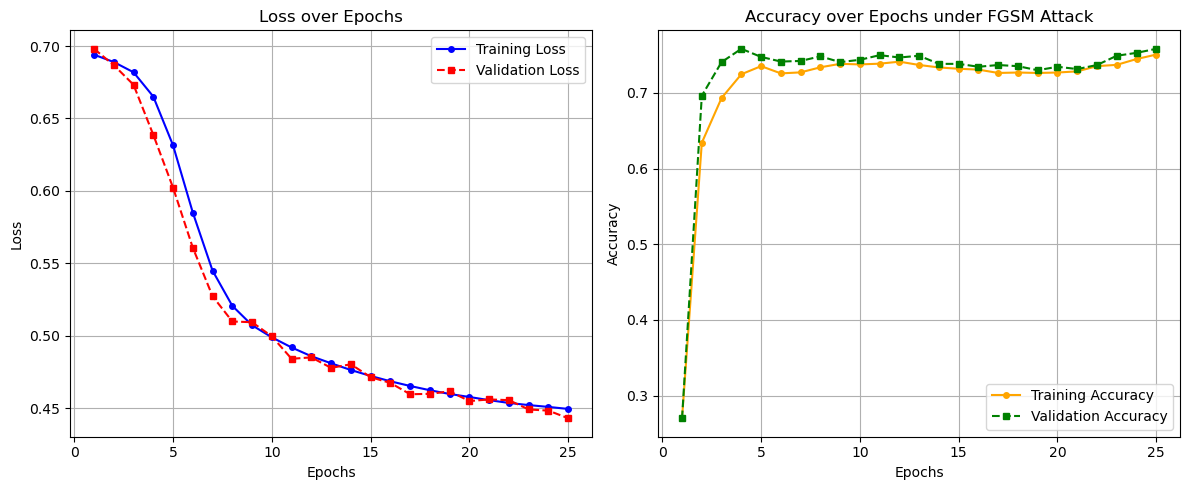

In [13]:
import matplotlib.pyplot as plt

# Function to plot loss and accuracy
def plot_loss_accuracy(loss_values, val_losses, accuracy_values, val_accuracy_values):
    epochs = range(1, len(loss_values) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss (Training and Validation)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_values, label='Training Loss', color='blue', marker='o', markersize=4, linestyle='-')
    plt.plot(epochs, val_losses, label='Validation Loss', color='red', marker='s', markersize=4, linestyle='--')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    # Plot Accuracy (Training and Validation)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy_values, label='Training Accuracy', color='orange', marker='o', markersize=4, linestyle='-')
    plt.plot(epochs, val_accuracy_values, label='Validation Accuracy', color='green', marker='s', markersize=4, linestyle='--')
    plt.title('Accuracy over Epochs under FGSM Attack')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plotting function after training
plot_loss_accuracy(loss_values, val_losses, accuracy_values, val_accuracy_values)


# Step 5: Visualize Results

Files saved to:
/home/HardDisk/yared/training_plot.pdf
/home/HardDisk/yared/training_plot.png


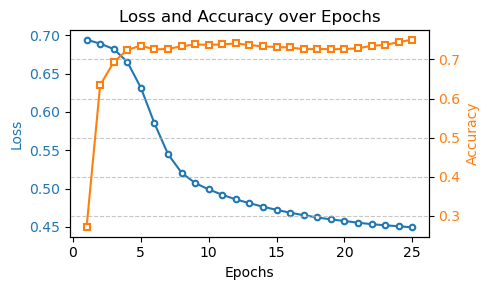

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

def plot_loss_accuracy(loss_values, accuracy_values):
    # Get current directory and create paths
    current_dir = os.getcwd()
    pdf_path = os.path.join(current_dir, 'training_plot.pdf')
    png_path = os.path.join(current_dir, 'training_plot.png')
    
    # Set up the plot with your original dimensions
    plt.figure(figsize=(5, 3))
    
    # Plot Loss (left y-axis) with enhanced styling
    plt.plot(range(1, len(loss_values) + 1), 
            loss_values, 
            label='Loss', 
            color='#1f77b4',
            marker='o',
            markerfacecolor='white',
            markeredgecolor='#1f77b4',
            markeredgewidth=1.5,
            markersize=4)
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss', color='#1f77b4')
    plt.tick_params(axis='y', labelcolor='#1f77b4')
    
    # Plot Accuracy (right y-axis) with enhanced styling
    ax2 = plt.gca().twinx()
    ax2.plot(range(1, len(accuracy_values) + 1), 
            accuracy_values, 
            label='Accuracy', 
            color='#ff7f0e',
            marker='s',
            markerfacecolor='white',
            markeredgecolor='#ff7f0e',
            markeredgewidth=1.5,
            markersize=4)
    
    ax2.set_ylabel('Accuracy', color='#ff7f0e')
    ax2.tick_params(axis='y', labelcolor='#ff7f0e')
    
    # Add titles and legends as in your original
    plt.title('Loss and Accuracy over Epochs')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Save high quality versions
    plt.savefig(pdf_path, format='pdf', dpi=300, bbox_inches='tight')
    plt.savefig(png_path, format='png', dpi=600, bbox_inches='tight')
    print(f"Files saved to:\n{pdf_path}\n{png_path}")
    
    plt.show()

# Your original function call remains the same
plot_loss_accuracy(loss_values, accuracy_values)